# Setup Code

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import Input, Model
import os
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from ipywidgets import Text, Layout, Button
from IPython.display import display, Math, update_display
from latex2sympy2 import latex2latex

2024-02-13 19:43:58.097423: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 19:43:58.135679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_character_bounding_boxes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    output = cv2.connectedComponentsWithStats(
        thresh, 8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    new_stats = []
    added = [False for i in range(len(stats))]
    threshhold = .5
    for i in range(1,len(stats)):
        if added[i]:
            continue

        (xi, yi, wi, hi, ai) = stats[i]
        for j  in range(i+1,len(stats)):
            if added[j]:
                continue

            (xj, yj, wj, hj, aj) = stats[j]
            if xi<=xj:
                if xi+wi>=xj+wj:
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xi+wi>=xj:
                    o = xi+wi-xj
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

            if xj<xi:
                if xj+wj>=xi+wi:
                    xi = xj
                    wi = wj
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xj+wj>=xi:
                    o = xj+wj-xi
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

        new_stats.append([xi, yi, wi, hi, ai])
        added[i] = True

    new_stats = sorted(new_stats, key=lambda x: x[0])
    return new_stats

def binarize_image(img, threshold=127):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding with background-foreground inversion
    binary_img = cv2.threshold(img, threshold, 1, cv2.THRESH_BINARY_INV)[1]

    return binary_img

In [3]:
mapping = {'%': 0, '*': 1, '+': 2, '-': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '[': 14, ']': 15}
reverse_mapping = {0: '/', 1: '*', 2: '+', 3: '-', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '[', 15: ']'}

In [4]:
model = load_model('./models/fine_tuned_model.keras')

In [5]:
def format_input_img(img, bb):
    (x, y, w, h, a) = bb
    cropped = img[y:y+h, x:x+w]
    cropped = cv2.resize(cropped, (28, 28))
    return binarize_image(cropped)

### If want to change img path

In [6]:
images_dir = 'handwritten-full-test'
images = [f.path for f in os.scandir(images_dir)]
images

['handwritten-full-test/.ipynb_checkpoints',
 'handwritten-full-test/8+4.jpg',
 'handwritten-full-test/1+1.jpg',
 'handwritten-full-test/48-88.jpg',
 'handwritten-full-test/2x2.jpg',
 'handwritten-full-test/67+81-98+10.jpg',
 'handwritten-full-test/72_div_2.jpg',
 'handwritten-full-test/3x[2+9].jpg',
 'handwritten-full-test/123x359.jpg',
 'handwritten-full-test/14592_div_2x4-3.jpg']

# DEMO: Our Model

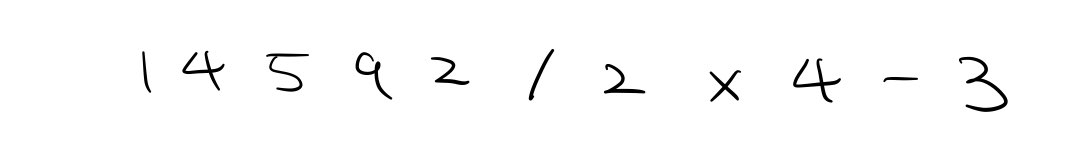

In [36]:
from PIL import Image
# Good: 0, 1, 2, 5
img = images[9]
img = cv2.imread(img)
bbs = get_character_bounding_boxes(img)
display(Image.fromarray(img))

In [37]:
count = 0
out_str = ""
for bb in bbs:
    char = format_input_img(img, bb)
    char = char.reshape(-1, 28, 28, 1) 
    yh_test = model.predict(char).argmax(axis=1)
    out_str += reverse_mapping[yh_test[0]]
    print(reverse_mapping[yh_test[0]])
print(f"FINAL: {out_str}")

1/1 [==============================] - 0s 47ms/step
1
1/1 [==============================] - 0s 31ms/step
4
1/1 [==============================] - 0s 32ms/step
5
1/1 [==============================] - 0s 34ms/step
9
1/1 [==============================] - 0s 33ms/step
2
1/1 [==============================] - 0s 35ms/step
/
1/1 [==============================] - 0s 33ms/step
2
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 26ms/step
-
1/1 [==============================] - 0s 26ms/step
3
FINAL: 14592/214-3


Text(value='14592/214-3')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

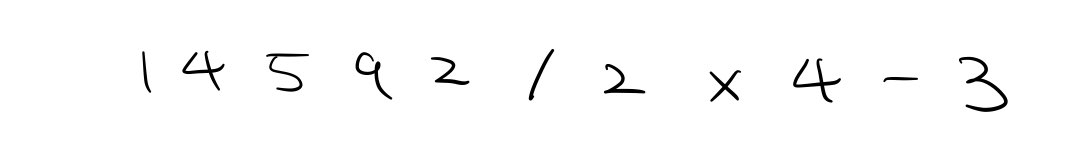

In [38]:
# Display the latex string
latex_str = out_str
text_box = Text(value=latex_str)
latex_math = Math(text_box.value)
solve_button = Button(description='Solve', layout=Layout(width='100%'))

def solve_latex(change):
    try:
        out = latex2latex(text_box.value)
        update_display(Math(out), display_id='latex_out')
    except:
        update_display("Bad Latex", display_id='latex_out')

def update_latex(change):
    update_display(Math(text_box.value), display_id='latex_in')
    solve_latex(None)

text_box.observe(update_latex, names='value')

display(text_box)
display("", display_id='latex_in')
display("", display_id='latex_out')
update_latex(None)
display(Image.fromarray(img))
print()

# DEMO: TrOCR

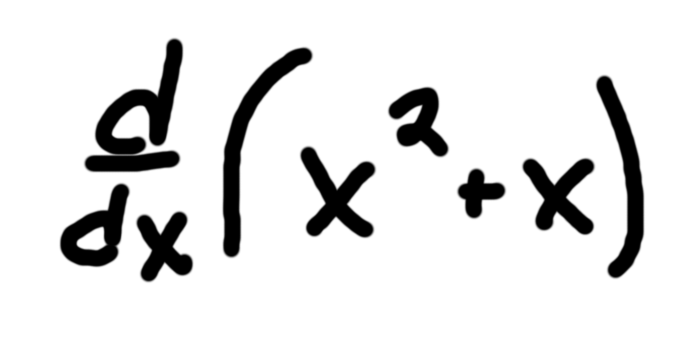

In [14]:
from PIL import Image
img = "demo-images/1.png"
img = cv2.imread(img)
bbs = get_character_bounding_boxes(img)
display(Image.fromarray(img))

In [ ]:
#TODO: Run model on img and save output into `latex_str`

In [119]:
from ipywidgets import Text, Layout, Button
from IPython.display import display, Math, update_display
from latex2sympy2 import latex2latex

text_box = Text(value=latex_str)
latex_math = Math(text_box.value)
solve_button = Button(description='Solve', layout=Layout(width='100%'))

def solve_latex(change):
    try:
        out = latex2latex(text_box.value)
        update_display(Math(out), display_id='latex_out')
    except:
        update_display("Bad Latex", display_id='latex_out')

def update_latex(change):
    update_display(Math(text_box.value), display_id='latex_in')
    solve_latex(None)

text_box.observe(update_latex, names='value')

display(text_box, clear=True)
display("", display_id='latex_in')
display("", display_id='latex_out')
update_latex(None)
print()

Text(value='\\frac{d}{dx}(x^{2}+x)')

<IPython.core.display.Math object>

<IPython.core.display.Math object>